## input

In [1]:
from glob import glob

mp3_filename = glob('audio/*.mp3')[0]

print('selected %s as input' % mp3_filename)

selected audio/XC653412.mp3 as input


In [2]:
import ffmpeg

wav_filename = mp3_filename.replace('mp3', 'wav')

mp3 = ffmpeg.input(mp3_filename)
wav = ffmpeg.output(mp3, wav_filename, f='wav')
try:
    out, err = ffmpeg.run(wav, capture_stderr=True, overwrite_output=True)
    print('OK')
    print('produced', wav_filename)
except ffmpeg.Error as e:
    print(e)
    print(e.stderr)

OK
produced audio/XC653412.wav


## spectrogram

In [3]:
from scipy.io.wavfile import read as readwav
from matplotlib import pyplot as plt
from scipy.signal import spectrogram
import numpy as np

In [4]:
rate, wav = readwav(wav_filename)

In [5]:
norm = {
    'int16': 32767.
}[wav.dtype.name]

wav = wav.astype(float) / norm

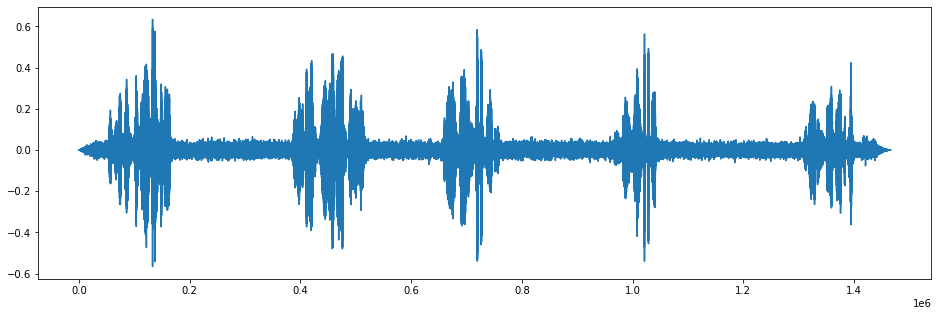

In [6]:
plt.figure(figsize=(16,5))
plt.plot(wav);

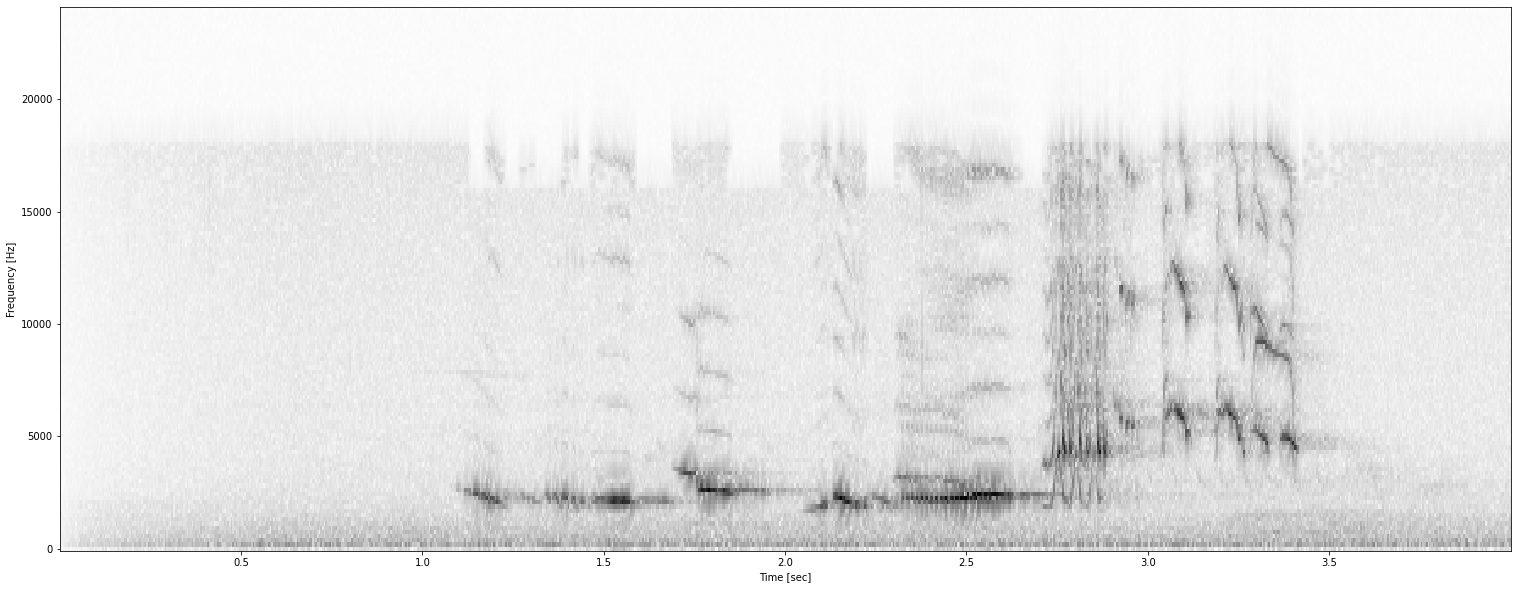

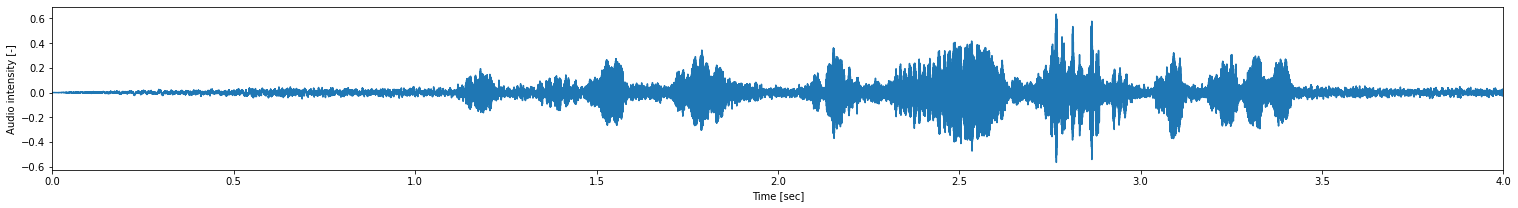

In [7]:
f, t, Sxx = spectrogram(wav[:4*rate], fs=rate)

plt.figure(figsize=(26,10))
plt.pcolormesh(t, f, Sxx**.125, shading='auto', cmap=plt.get_cmap('Greys'))
# plt.ylim((0,15e3))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]');

plt.figure(figsize=(26,3))
x = np.linspace(0., 4., 4*rate)
y = wav[:4*rate]
plt.plot(x, y)
plt.xlim(0, 4.)
plt.ylabel('Audio intensity [-]')
plt.xlabel('Time [sec]');

## classification

In [8]:
cutoff = np.where(f > 15e3)[0][0]

In [9]:
Sxx = Sxx[:cutoff, :]
f = f[:cutoff]

In [10]:
from scipy.cluster.vq import kmeans2
from matplotlib.patches import Rectangle

In [11]:
def plot_labeled_spectogram(t, f, Sxx, label):
    plt.figure(figsize=(26,10))
    plt.pcolormesh(t, f, Sxx**.125, shading='auto', cmap=plt.get_cmap('Greys'))

    ax = plt.gca()
    w = t[1] - t[0]
    labels = np.unique(label)
    for l, c in zip(labels, plt.get_cmap('tab10').colors[:len(labels)]):
        for x in t[label == l]:
            ax.add_artist(Rectangle((x, 0.), width=w, height=f.max(), color=c, alpha=.3, ls=''))

    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]');

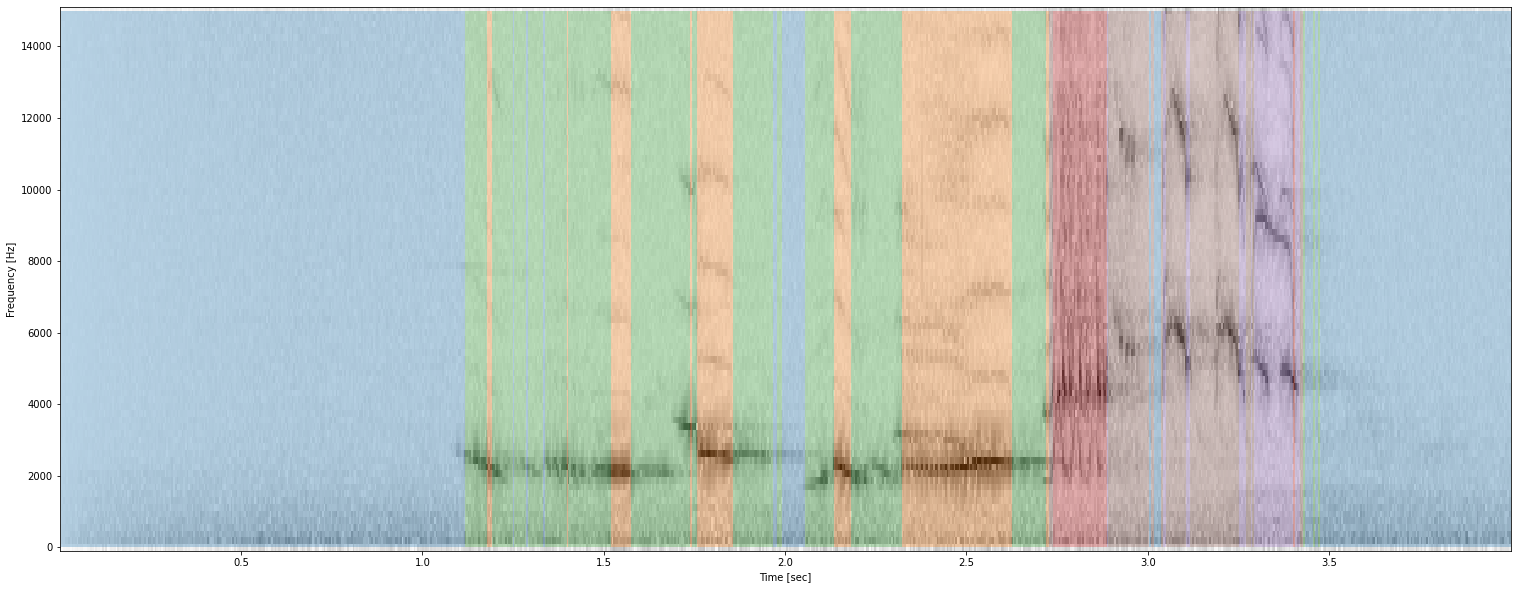

In [12]:
centroid, label = kmeans2(Sxx.T**.125, 6, minit='++')
plot_labeled_spectogram(t, f, Sxx, label)